# Carregamento das bases

In [58]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns

raw_target_dataset = pd.read_csv('/mnt/data/target_apartments1_wn.csv')
raw_target_dataset[['latitude', 'longitude']] = raw_target_dataset[['latitude', 'longitude']].astype(float)
raw_target_dataset.drop(columns=['point', 'neighborhood'], inplace=True)
#dummies = pd.get_dummies(raw_target_dataset['neighborhood'])
#raw_target_dataset = pd.concat([raw_target_dataset, dummies], axis=1).drop(columns='neighborhood')

raw_simulated_dataset = pd.read_csv('/mnt/data/simulated_listings1_wn.csv')
raw_simulated_dataset[['latitude', 'longitude']] = raw_simulated_dataset[['latitude', 'longitude']].astype(float)
raw_simulated_dataset.drop(columns=['point', 'neighborhood'], inplace=True)
#dummies = pd.get_dummies(raw_simulated_dataset['neighborhood'])
#raw_simulated_dataset = pd.concat([raw_simulated_dataset, dummies], axis=1).drop(columns='neighborhood')

# Análise inicial

In [59]:
profile = ProfileReport(raw_simulated_dataset, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
from keplergl import KeplerGl
map_1 = KeplerGl(height=800)
map_1.add_data(data=raw_simulated_dataset)
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

In [55]:
map_1.save_to_html(file_name='/mnt/data/analysis1_map.html')

Map saved to /mnt/data/analysis1_map.html!


# Estratégia escolhida

Escolhemos primeiramente atacar o problema de previsão de preço pois para os apartamentos que devem ser comprados não temos o preço correto necessáriamente e precisamos desse preço para inputar na previsão de liquidez, pois são coisas que parecem intimamente ligadas por intuição.
Com o preço estimado estimaremos a liquidez projetada para cada apartamento e com isso poderemos rankear os melhores apartamentos em termos de dinheiro/dia para melhor alocar nossos recursos.

# Questão 1

## Modelo de estimativa de preço

Começaremos pelo modelo de preço. Primeiro separamos a base de treino e teste.

O modelo é necessário para estimar o valor de venda do apartamento, seja ele com ou sem reforma necessária. Para isso não foi considerada a variável time_on_market por se tratar de uma variável que não necessariamente temos para apartamentos que vamos comprar.

In [65]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RepeatedKFold, cross_validate
X = raw_simulated_dataset.drop(['value', 'sold', 'time_on_market'], axis=1)
X_price = X
y = raw_simulated_dataset['value']
y_price = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

O modelo escolhido foi XGboost como um ponto de partida para responder a solução.

XGBoost é um bom modelo de prateleira e pela minha experiência em problemas de regressão é um modelo que se sai bem em problemas desse tipo. Além disso por ser um modelo de árvore ele é explicável, usando bibliotecas como SHAP por exemplo, o que facilita no entendimento do problema e da solução.

XGBoost é definido como um modelo de árvore de decisão com boost de gradiente. Ele é um ensemble de modelos árvores de decisão fracos, que com a união de vários modelos fracos consegue atingir um bom nível de performance, maior que um modelo de árvore comum como RandomForest e sem perder a explicabilidade. 

In [3]:
from sklearn.metrics import mean_squared_error
from numpy import absolute
import xgboost as xgb

In [4]:
model=xgb.XGBRegressor(learning_rate = 0.01,
                           n_estimators  = 500,
                           max_depth     = 5,
                           eval_metric='rmsle')

Foi escolhido como métrica de evaluation do modelo a mean squared logarithmic error porque essa métrica é recomendada quando os targets possuem crescimento exponencial, como por exemplo preço dos apartamentos.
Essa escolha é feita é para não penalizar grandes diferenças entre a predição e o valor real. Como estamos lidando com valores muito grandes esse cuidado se faz necessário.

In [5]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=8)

scores = cross_val_score(model, X, y, scoring='neg_mean_squared_log_error', cv=cv, n_jobs=-1)
print('Mean RMSLE: %.3f (%.3f)' % (absolute(scores.mean()), scores.std()))

Mean RMSLE: 0.038 (0.002)


Foi escolhida fazer a validação cruzada para garantir que os dados estejam apresentados de forma homogênea, reduzindo o viés do modelo e avaliando a capacidade de generalização do modelo.

In [6]:
score = cross_validate(model, X, y, scoring='neg_mean_squared_log_error', cv=cv, n_jobs=-1, return_estimator=True)
test_score_abs = absolute(score['test_score'])
best_model_idx = np.where(test_score_abs == test_score_abs.min())
model_best = score['estimator'][best_model_idx[0][0]]
price_model = model_best

In [7]:
import pickle
file_name = "/mnt/data/xgb_price_regressor.pkl"

# save
#pickle.dump(model_best, open(file_name, "wb"))

In [8]:
preds = model_best.predict(X_test)
df_preds = pd.DataFrame(y_test)
df_preds['preds'] = preds

df_preds

value         preds
6446   544249  6.171596e+05
6393   627876  6.203285e+05
4924  2054370  2.281459e+06
6480  1004540  1.201509e+06
4455  1326930  9.538582e+05
...       ...           ...
885   1365730  1.701445e+06
3042   908762  9.127916e+05
530    487133  6.860983e+05
7752  3097650  3.029174e+06
6190   974241  7.848859e+05

[1256 rows x 2 columns]

In [61]:
def relative_error(model, X, y):
    preds = model.predict(X)
    df_preds = pd.DataFrame()
    df_preds['target'] = y 
    df_preds['preds'] = preds
    df_preds['relative_error'] = (df_preds['target'] - df_preds['preds'])/df_preds['target']
    df_preds['latitude'] = X['latitude'] 
    df_preds['longitude'] = X['longitude']
    df_preds['error'] = df_preds['target'] - df_preds['preds']
    
    return df_preds

In [66]:
rel_error_df = relative_error(model_best, X_price, y_price)


Plotamos o hitsograma do erro para verificar se as predições se apresentam como uma distribuição centrada em zero, para dectectar possíveis outliers também.

Vemos que está centrada em zero porém há uma concentração muito grande de valores no meio.

<AxesSubplot:xlabel='error', ylabel='Count'>

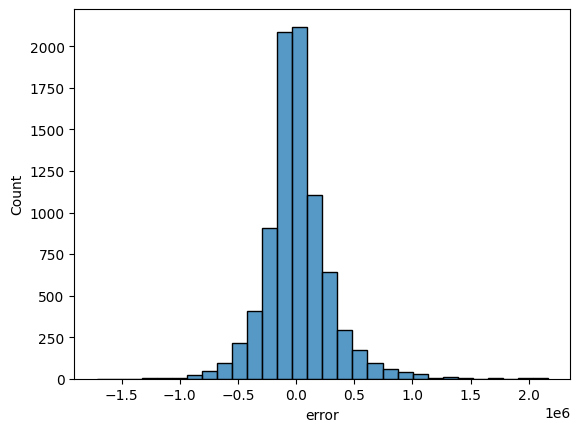

In [67]:
sns.histplot(data=rel_error_df, x="error", bins=30)

<AxesSubplot:xlabel='relative_error', ylabel='Count'>

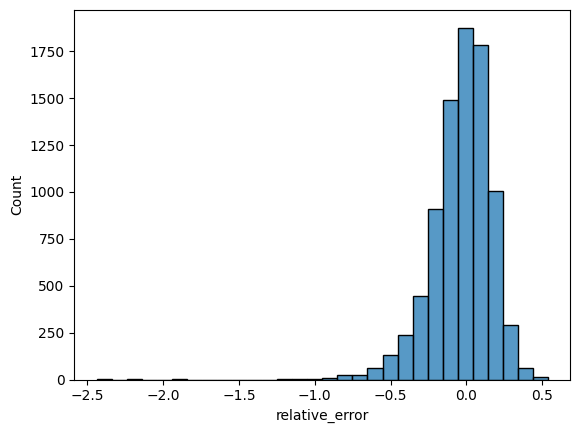

In [69]:
sns.histplot(data=rel_error_df, x="relative_error", bins=30)

In [52]:
from keplergl import KeplerGl
map_1 = KeplerGl(height=800)
map_1.add_data(data=rel_error_df)
#map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


Por este mapa podemos entender melhor para que quadrantes/localidades o modelo está com o erro relativo menor ou maior com relação também ao valor médio dos apartamentos no dataset dessa área, além da representatividade no dataset. 

Podemos ter uma noção de localidades que devemos enriquecer os dados com mais apartamentos transicionados em outras fontes de dados ou até melhorar as features com relação a áreas para capturar melhor as diferenças de um local a outro. Por ex.: renda per capta.

Essas features ajudam na generalização do modelo para datasets diferentes do que estamos trabalhando atualmente.

In [12]:
map_1.save_to_html(file_name='/mnt/data/relative_error_map.html')

Map saved to /mnt/data/relative_error_map.html!


## Modelo de estimativa de tempo até a venda

Aqui me baseei em alguns artigos no blog da loft sobre análise de sobrevivência como saída para não construir um modelo enviesado somente com os casos em que já houve o evento de venda do apartamento. O modelo objetivo apropriada para sobrevivência escolhida foi a aft. 

Modelo AFT assume que uma dada variável multiplica o evento por uma constante que acelera ou desacelera o acontecimento do mesmo.

O modelo cox,  por ser um modelo semi-paramétrico, conseguimos treinar modelos sem saber ou assumir a distribuição dos dados do problema escolhido. A outra possibilidade seria o uso do modelo AFT que seria um modelo paramétrico que é muito sensível a destribuição dos dados, porém diferentemente da cox este modelo retorna o valor do tempo até o evento, diferentemente do cox que retorna o risco relativo.

O AFT utiliza valores de evento com intervalos de tempo, no caso de eventos que ocorreram [T, T] , no caso de censurados [T, inf]

In [77]:
raw_simulated_dataset_cox = raw_simulated_dataset.copy()
mask = (raw_simulated_dataset['sold']==1)
raw_simulated_dataset_cox['sold'] = mask
X = raw_simulated_dataset_cox.drop(['time_on_market'], axis=1)
X_liquidity = X.drop(['sold'], axis=1)
y = raw_simulated_dataset_cox['time_on_market']
y_liquidity = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_eval, X_test, y_eval, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [14]:
xgb_train = xgb.DMatrix(X_train.drop(['sold'], axis=1))
xgb_test = xgb.DMatrix(X_test.drop(['sold'], axis=1))
xgb_eval = xgb.DMatrix(X_eval.drop(['sold'], axis=1))


y_lower_bound = y_train
y_upper_bound = np.where(X_train['sold'], y_train, np.inf)
xgb_train.set_float_info("label_lower_bound", y_lower_bound.copy())
xgb_train.set_float_info("label_upper_bound", y_upper_bound.copy())

y_lower_bound = y_test
y_upper_bound = np.where(X_test['sold'], y_test, np.inf)
xgb_test.set_float_info("label_lower_bound", y_lower_bound.copy())
xgb_test.set_float_info("label_upper_bound", y_upper_bound.copy())

y_lower_bound = y_eval
y_upper_bound = np.where(X_eval['sold'], y_eval, np.inf)
xgb_eval.set_float_info("label_lower_bound", y_lower_bound.copy())
xgb_eval.set_float_info("label_upper_bound", y_upper_bound.copy())

In [15]:
params = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'extreme',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'hist', 
    'learning_rate': 0.005, 
    'max_depth': 8, 
    'booster':'gbtree',
    'subsample':0.5,
    'min_child_weight': 50,
    'colsample_bynode':0.5
}

liquidity_model = xgb.train(params, xgb_train, num_boost_round=1200, evals=[(xgb_eval, 'eval')], early_stopping_rounds=10, verbose_eval=100)

[0]	eval-aft-nloglik:26.01140
[100]	eval-aft-nloglik:25.16097
[200]	eval-aft-nloglik:23.74012
[300]	eval-aft-nloglik:21.87872
[400]	eval-aft-nloglik:19.33919
[500]	eval-aft-nloglik:16.10321
[600]	eval-aft-nloglik:12.39971
[700]	eval-aft-nloglik:8.61471
[800]	eval-aft-nloglik:6.12007
[900]	eval-aft-nloglik:4.67399
[1000]	eval-aft-nloglik:3.85175
[1100]	eval-aft-nloglik:3.39478
[1199]	eval-aft-nloglik:3.14807


In [16]:
import lifelines
y_pred = liquidity_model.predict(xgb_test)
c_index = lifelines.utils.concordance_index(y_test, y_pred)
print(f"C-index: {c_index:.3f}")
print(f"Average survival time: {y_pred.mean():.0f} days")

C-index: 0.608
Average survival time: 109 days


O c-index é uma métrica que avalia a acurácia do ranking da predição do tempo baseada nos scores de risco individuais. É uma generalização da AUC, area under the curve, baseada na área abaixo da curva ROC em que taxas true positive é plotada contra as taxas de falso positivos. No caso do c-index consegue  levar em consideração dados censurados. 


No caso do c-index temos:
- 0.5 é um resultado randômico
- 1.0 é uma concordância perfeita
- 0.0 é uma perfeita anti-concodância 

In [17]:
import pickle
file_name = "/mnt/data/xgb_liquidity_survival_aft.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

# load
#xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [79]:
xgb_full = xgb.DMatrix(X_liquidity)
y_lower_bound = y_liquidity
y_upper_bound = np.where(X['sold'], y_liquidity, np.inf)
xgb_full.set_float_info("label_lower_bound", y_lower_bound.copy())
xgb_full.set_float_info("label_upper_bound", y_upper_bound.copy())

In [82]:
def relative_error_liq(model, X_dm, y, X):
    preds = model.predict(X_dm)
    df_preds = pd.DataFrame()
    df_preds['target'] = y 
    df_preds['preds'] = preds
    df_preds['relative_error'] = (df_preds['target'] - df_preds['preds'])/df_preds['target']
    df_preds['latitude'] = X['latitude'] 
    df_preds['longitude'] = X['longitude']
    df_preds['error'] = df_preds['target'] - df_preds['preds']
    
    return df_preds

In [83]:
rel_error_df_liq = relative_error_liq(liquidity_model, xgb_full, y_liquidity, X_liquidity)


<AxesSubplot:xlabel='error', ylabel='Count'>

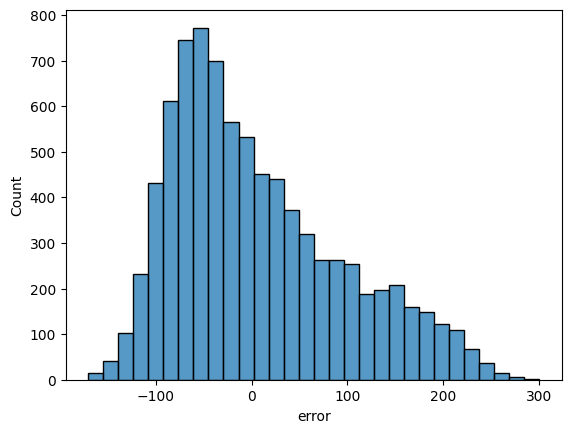

In [84]:
sns.histplot(data=rel_error_df_liq, x="error", bins=30)

<AxesSubplot:xlabel='relative_error', ylabel='Count'>

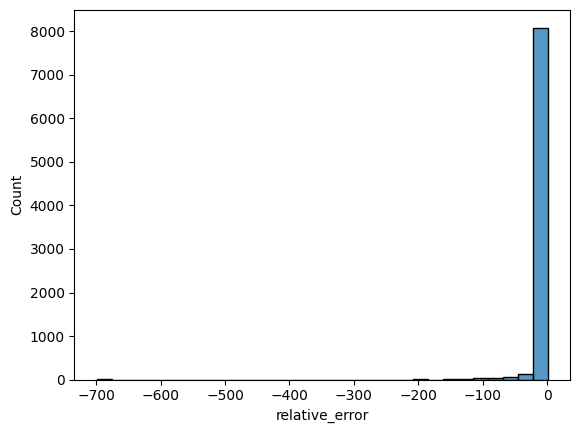

In [85]:
sns.histplot(data=rel_error_df_liq, x="relative_error", bins=30)

In [18]:
import shap
shap_values = shap.TreeExplainer(liquidity_model).shap_values(X_liquidity)

Podemos avaliar o impacto de cada variável do modelo usando a biblioteca SHAP que utiliza um approach de teoria dos jogos que é agnóstico de modelo. Com os SHAP values podemos entender a contribuição positiva ou negativa e a proporção da mesma para o valor final da predição do modelo.

No gráfico abaixo de SHAP podemos ver a contribuição de valor para a liquidez, valores negativos contribuem negativamente para o aumento dos dias até a venda, ou seja quanto menor o valor do apartamento maior é sua liquidez (tempo de venda menor).


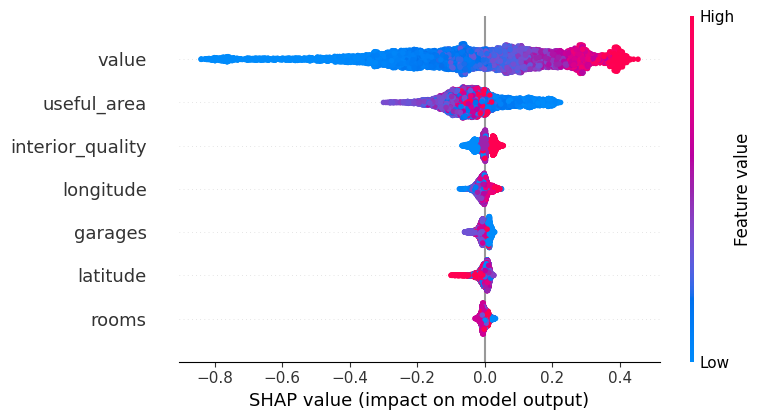

In [19]:
shap.summary_plot(shap_values, X_liquidity)

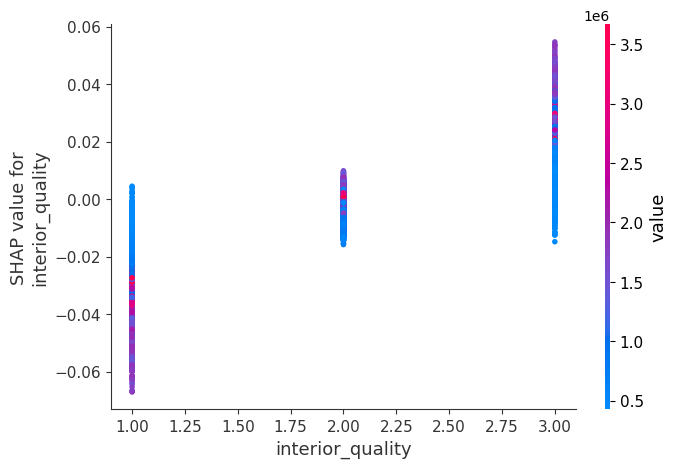

In [20]:
shap.dependence_plot("interior_quality", shap_values, X_liquidity)

# Questão 2

In [22]:
# load
#file_name = "/mnt/data/xgb_price_regressor.pkl"
#price_model = pickle.load(open(file_name, "rb"))

In [23]:
# load
#file_name = "/mnt/data/xgb_liquidity_survival_cox.pkl"
#liquidity_model = pickle.load(open(file_name, "rb"))

Diretrizes:
- Pagamos exatamente o valor pedido pelo proprietário (coluna value na base
target_apartments.csv ).
- A reforma traz o apartamento para o melhor estado de conservação possível
( interior_quality=3 ).
- O capital disponível para compra dos apartamentos é de R$ 150 milhões.

In [24]:
raw_target_df_iq = raw_target_dataset.copy()
raw_target_df_iq['interior_quality']=3

In [25]:
X= raw_target_df_iq.drop(['value'], axis=1)
sell_value_preds = price_model.predict(X)

In [26]:
raw_target_df_iq = raw_target_df_iq.rename(columns={'value': 'buy_value'})
raw_target_df_iq['value']=sell_value_preds

## Prever Liquidity (time_on_market) com o sell_value

In [27]:
X = raw_target_df_iq.drop(['buy_value'], axis=1)
X.columns =  ['rooms', 'garages', 'useful_area', 'latitude', 'longitude', 'value', 'interior_quality'] 
X_dmatrix = xgb.DMatrix(X)
time_on_market_pred = liquidity_model.predict(X_dmatrix)
raw_target_df_iq['time_on_market'] = time_on_market_pred

## Rankear e selecionar apartamentos até valor de 150mi

In [28]:
rank_df = raw_target_df_iq[['buy_value', 'value', 'time_on_market']]
rank_df['money_per_time'] = (rank_df['value'] - rank_df['buy_value'])/ rank_df['time_on_market']
rank_df_ordered = rank_df.sort_values(by=['money_per_time'], ascending=False)
rank_df_ordered['cum_sum'] = rank_df_ordered['value'].cumsum()
best_apts_df = rank_df_ordered[rank_df_ordered['cum_sum']<150000000]
best_apts_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


buy_value       value  time_on_market  money_per_time      cum_sum
3494    1235190  3052390.00       56.385727    32228.014056    3052390.0
561     2536710  4498312.00       63.304195    30986.919389    7550702.0
3593    1653800  3185316.75       61.554188    24880.788869   10736019.0
1925    1786500  3265745.75       60.105869    24610.670595   14001765.0
6515    1839720  3517526.00       68.742439    24407.135066   17519292.0
2324    1561710  2977790.00       59.626064    23749.345468   20497082.0
2375    2341220  3764195.00       60.197739    23638.346423   24261276.0
4656    1429770  2649213.25       52.688435    23144.419819   26910490.0
5450    2369380  3736447.50       61.064625    22387.225088   30646938.0
6781    1875720  3282029.50       63.250095    22234.108768   33928968.0
4237    1797290  2948175.25       52.133656    22075.667587   36877144.0
4373    2199480  3350024.50       52.639431    21857.084663   40227168.0
2452    2076180  3306614.00       57.016663    21580.252929   43533784.0
4015    1731870  3005395.75       59.255219    21492.212536   46539180.0
5125    1972130  3196113.25       57.157833    21414.094685   49735292.0
7308    1733610  3033916.25       61.142597    21266.781419   52769208.0
6143    1766710  3055593.00       61.325848    21016.961851   55824800.0
3889    1202560  2377230.50       56.356403    20843.603036   58202032.0
6567    1526470  2669956.50       56.113163    20378.222131   60871988.0
7967    2163220  3472281.50       64.592850    20266.353094   64344268.0
1021    2063020  3167879.25       55.614559    19866.367124   67512144.0
6608    2920310  4197254.00       64.917091    19670.382222   71709400.0
6706    2149540  3376082.75       64.068916    19144.115750   75085480.0
2737    1751730  2882026.00       60.477367    18689.570141   77967504.0
3759    2292960  3460059.50       62.505402    18671.978260   81427560.0
3805    1926740  2980109.75       56.478050    18650.958128   84407672.0
5549    2630360  3790025.50       62.323528    18607.186272   88197696.0
7378    2315040  3380657.75       57.526768    18523.859275   91578352.0
264     2083440  3278601.50       64.545280    18516.636562   94856952.0
3648    3090200  4284708.50       64.800743    18433.561759   99141664.0
5806    2397750  3415661.00       56.810112    17917.778441  102557328.0
6869    1006220  1987357.25       55.939648    17539.210395  104544688.0
2124    1006220  1987357.25       55.939648    17539.210395  106532048.0
3213    1006220  1987357.25       55.939648    17539.210395  108519408.0
3348    2696680  3819375.50       64.288887    17463.290344  112338784.0
2053    1279940  2170824.50       51.029762    17458.135418  114509608.0
1675    2634430  3628308.50       57.033466    17426.233469  118137920.0
5267    1860900  2943209.25       62.339191    17361.618350  121081128.0
277     2895200  3906821.25       58.477505    17299.323127  124987952.0
2350    2153420  3113449.25       55.513851    17293.508374  128101400.0
293     1604940  2682271.00       62.429356    17256.801536  130783672.0
7389    1805330  2758211.00       55.707638    17105.033311  133541880.0
1329    2834540  3914765.25       63.594036    16986.266578  137456640.0
2213    2535310  3651351.50       66.143608    16873.006057  141107984.0
1282    2287020  3213252.00       56.026566    16532.014606  144321232.0
1042    1693920  2587722.00       54.199928    16490.833628  146908960.0
7393    1912200  2932084.00       62.086945    16426.706241  149841040.0

# Questão 3

In [29]:
shap.initjs()

In [30]:
shap_values = shap.TreeExplainer(liquidity_model).shap_values(X_liquidity)

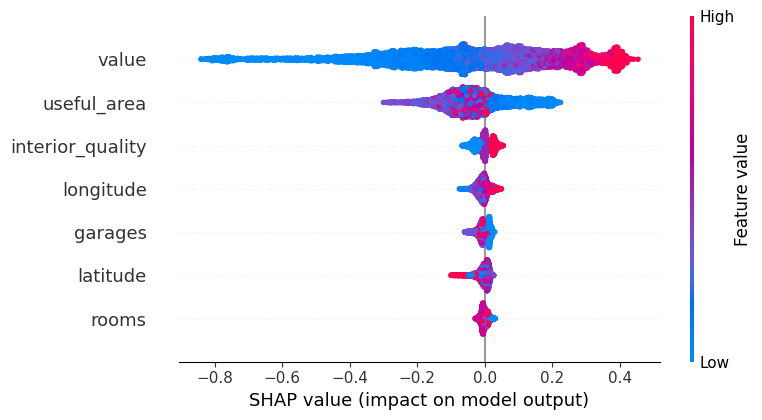

In [31]:
shap.summary_plot(shap_values, X_liquidity)

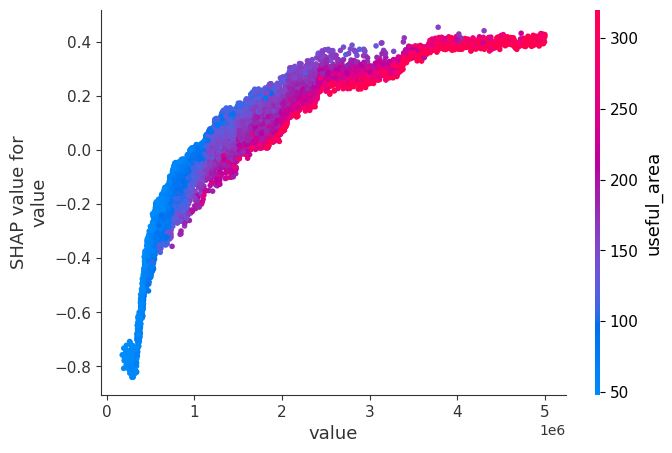

In [32]:
shap.dependence_plot("value", shap_values, X_liquidity)

<AxesSubplot:xlabel='time_on_market', ylabel='Count'>

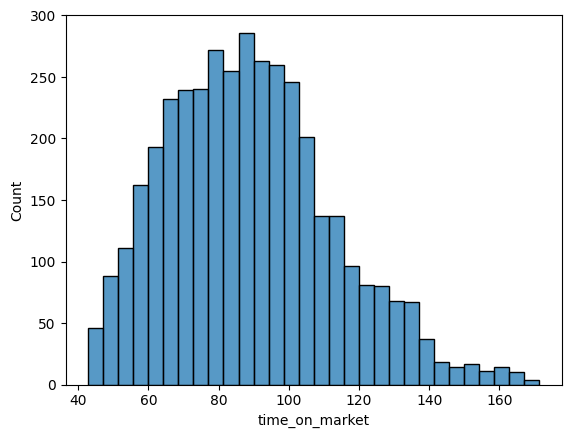

In [35]:
raw_simul_dataset_10off = raw_simulated_dataset.copy()[raw_simulated_dataset['sold'] ==1]
raw_simul_dataset_10off['value'] = raw_simul_dataset_10off['value']*0.9
X_10off = raw_simul_dataset_10off.drop(['time_on_market', 'sold'], axis=1)
X_10off.columns =  ['rooms', 'garages', 'useful_area', 'latitude', 'longitude', 'value', 'interior_quality'] 
X_10off_dm = xgb.DMatrix(X_10off)
time_on_market_pred = liquidity_model.predict(X_10off_dm)
raw_simul_dataset_10off['time_on_market'] = time_on_market_pred
sns.histplot(data=raw_simul_dataset_10off, x="time_on_market", bins=30)

<AxesSubplot:xlabel='time_on_market', ylabel='Count'>

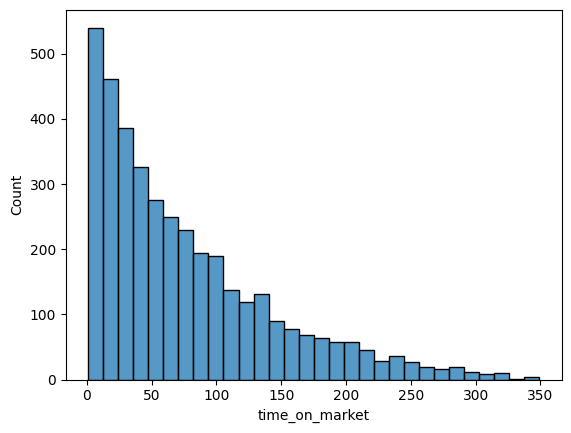

In [36]:
sns.histplot(data=raw_simulated_dataset[raw_simulated_dataset['sold'] ==1], x="time_on_market", bins=30)

<AxesSubplot:xlabel='time_on_market', ylabel='Count'>

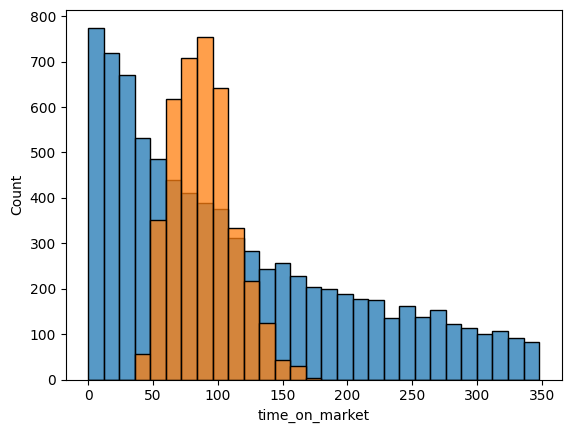

In [37]:
import matplotlib.pyplot as plt

plot_df = pd.DataFrame()
plot_df['time_on_market'] = raw_simulated_dataset['time_on_market']
plot_df['time_on_market_10off'] = raw_simul_dataset_10off['time_on_market']
fig, ax = plt.subplots()
sns.histplot(plot_df['time_on_market'], bins=range(0, 350, 12), ax=ax, kde=False)
sns.histplot(plot_df['time_on_market_10off'], bins=range(0, 350, 12), ax=ax, kde=False)

<AxesSubplot:xlabel='time_on_market_diff', ylabel='Count'>

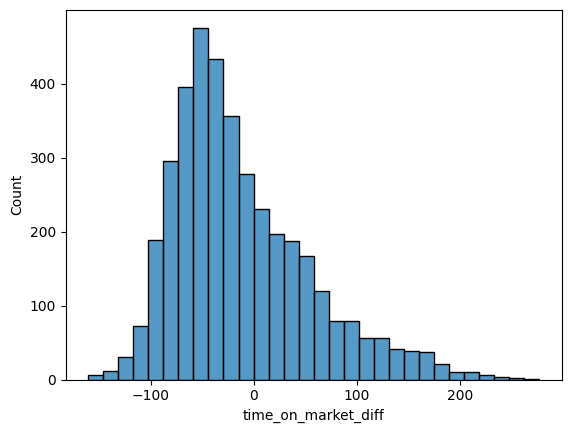

In [38]:
raw_simul_dataset_10off['time_on_market_diff'] = raw_simulated_dataset['time_on_market']  - raw_simul_dataset_10off['time_on_market'] 
sns.histplot(data=raw_simul_dataset_10off, x="time_on_market_diff", bins=30)

In [39]:
raw_simul_dataset_10off['time_on_market_diff'].mean() 

-12.260807080557294

# Questão 4

## Price

In [40]:
X_price_sample = X_price.sample(500, random_state=10)

In [41]:
explainer = shap.TreeExplainer(price_model)
shap_values = explainer.shap_values(X_price)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [42]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_price.iloc[0,:])

O gráfico acima serve para demonstrar a contribuição no modelo para aumentar ou diminuir um valor. O azul significa uma diminuição no valor do apartamento para o modelo.

In [43]:
#shap.force_plot(explainer.expected_value, shap_values, X_price.sample())

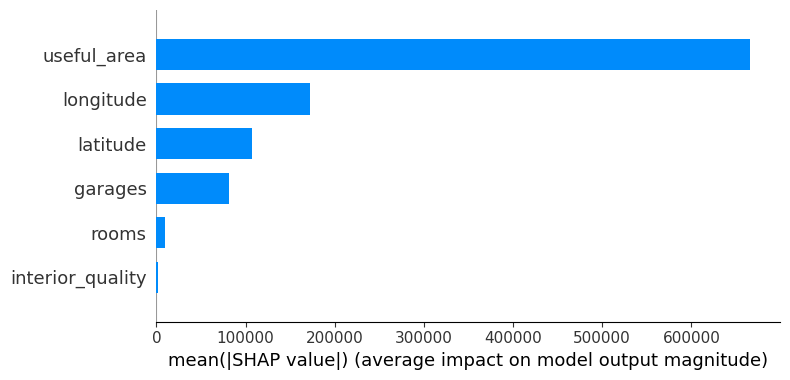

In [44]:
shap.summary_plot(shap_values, X_price, plot_type='bar')

## Liquidity

In [45]:
X_liquidity_sample = X_liquidity.sample(500, random_state=10)

In [46]:
explainer_liquidity = shap.TreeExplainer(liquidity_model)
shap_values_liquidity = explainer_liquidity.shap_values(X_liquidity)

In [47]:
shap.force_plot(explainer_liquidity.expected_value, shap_values_liquidity[0,:], X_liquidity.iloc[0,:])

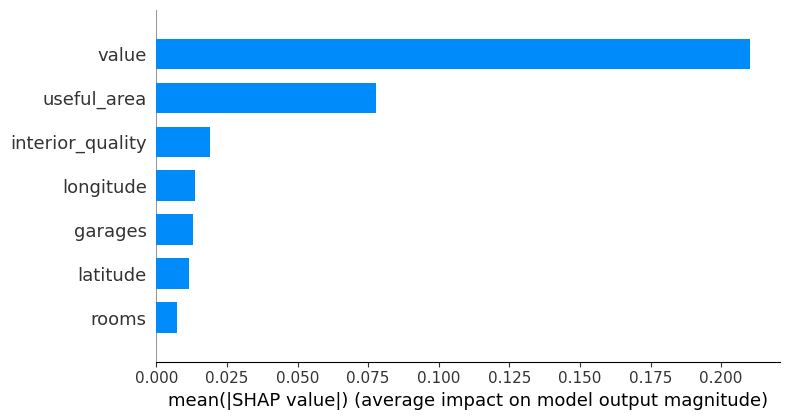

In [51]:
shap.summary_plot(shap_values_liquidity,X_liquidity, plot_type='bar')

In [86]:
#Evento
E = (raw_simulated_dataset.sold)
# Tempo até evento
T = raw_simulated_dataset.time_on_market

group1 = (raw_simulated_dataset.interior_quality == 3)
label1 = "Interior Quality = 3"
group2 = (raw_simulated_dataset.interior_quality < 3)
label2 = "Interior Quality < 3"

In [91]:
from matplotlib.offsetbox import AnchoredText
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines import KaplanMeierFitter
def km_and_logrank(group1, group2, T, E, label1, label2):
    """
    group1: booleans identificando o grupo 1
    group2: booleans identificando o grupo 2
    T: pd.Series identificando o tempo da análise de sobrevivência
    E: pd.Series identificando o evento (censurado ou evento) da análise de sobrevivência
    label1: nome do grupo 1
    label2: nome do grupo 2
    """
    T1=T[group1]
    E1=E[group1]
    
    T2=T[group2]
    E2=E[group2]

    #logrank_test
    results=logrank_test(T1,T2,event_observed_A=E1, event_observed_B=E2)

    #Kaplan Meier plot
    kmf = KaplanMeierFitter()

    ax = plt.subplot(111)
    ax = kmf.fit(T1, E1, label=f"{label1}").plot(ax=ax, ci_show=True, show_censors=False)
    ax = kmf.fit(T2, E2, label=f"{label2}").plot(ax=ax, ci_show=True, show_censors=False)
    ax.set_xlabel('time_to_market')
    ax.set_ylabel('Survival function')
    plt.ylim([0, 1.1])
    anchored_text = AnchoredText("log-rank p-value: {:.3}".format(results.p_value), loc=3, frameon=False)
    ax.add_artist(anchored_text)

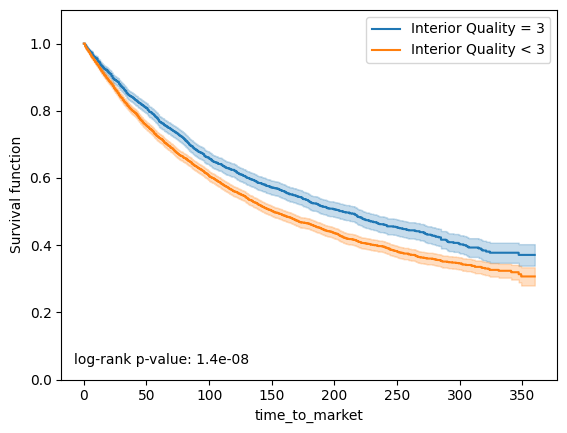

In [92]:
group1 = (raw_simulated_dataset.interior_quality == 3)
label1 = "Interior Quality = 3"
group2 = (raw_simulated_dataset.interior_quality < 3)
label2 = "Interior Quality < 3"

km_and_logrank(group1, group2, T, E, label1, label2)

As curvas de sobrevivência são consideravelmente diferentes entre si podemos ver pelo p-value <0.005